In [1]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import models
import os
import matplotlib.pyplot as plt
from PIL import Image
import math
import cv2

print(torch.__version__)
device = torch.device('cuda:0')

1.2.0


calculate R = dL/dx by guided backprop

In [2]:
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, torch.nn.ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        image = Variable(input_image, requires_grad=True)
        model_output = self.model(image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


In [3]:
pretrained_model = models.alexnet(pretrained = True)
GBP = GuidedBackprop(pretrained_model)

In [4]:
class calTech(Dataset):
    def __init__(self, name, transform=None):
        hf = h5py.File(name, 'r')
        self.input_images = np.array(hf.get('features'))
        self.input_labels = np.array(hf.get('labels')).astype(np.long)
        self.transform = transform
        hf.close()

    def __len__(self):
        return (self.input_images.shape[0])

    def __getitem__(self, idx):
        images = self.input_images[idx]
        labels = self.input_labels[idx]
        if self.transform is not None:
            images = self.transform(images)
        return images, labels
    
BATCH_SIZE = 1
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

classes = [str(i) for i in range(102)]

data_path = os.path.dirname(os.getcwd()) + "/data/calTech/"
Train_data = calTech(data_path + "train.h5", transform=normalize)
Train_dataloader = DataLoader(dataset=Train_data, batch_size = 1, shuffle=True)

In [39]:
image, label = next(iter(Train_dataloader))
output = pretrained_model(image)
cl = torch.argmax(output)
print(cl)
gradients_as_arr = GBP.generate_gradients(image, cl.item())

tensor(936)


(3, 224, 224)


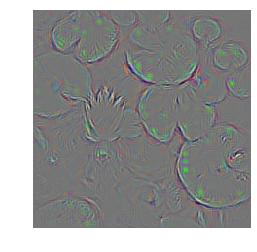

In [40]:
def gradient_to_img(gradient):
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    print(gradient.shape)
    return np.transpose(gradient, (1, 2, 0))

def imshow(gradients_arr, title):
    """Custom function to display the image using matplotlib"""    
    npimg = gradient_to_img(gradients_arr)
    #plot the numpy image
    plt.figure(figsize = (4, 4))
    plt.axis("off")
    plt.imshow(npimg)
    plt.title(title)
    plt.show()

imshow(gradients_as_arr, "")